Notebook analysing object distribution in the Andes Data Release. Made to be compatible with:
- Catalogue files (using the object DrqFile)
- Tiles from the Andes Data Release (for each tile it is loaded every zbestfile for all nights)

In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

sys.path.append('..')
tids_path = '../Data/tids_stephen.txt'
from LyaPlotter.computations import Computations
from LyaPlotter.plotter import Plotter
from LyaPlotter.sims import CoLoReSim, LyaCoLoReSim, QuickQuasarsSim
from LyaPlotter.file_types_minisv import zBestFilesMiniSV, CoaddFilesMiniSV, DrqFile
from LyaPlotter.file_types import cached_property


In [3]:
def np_to_magn(flux):
    return 22.5 - 2.5*np.log10(flux)

# Check drq file QSOs

### Checking the homemade catalogue done by Christophe:

In [4]:
x = DrqFile('/global/cfs/cdirs/desi/science/lya/tests_andes/qso_catalogs/preliminary_christophe_20200622.fits')

In [5]:
_= list(map(np_to_magn,x.flux_r))

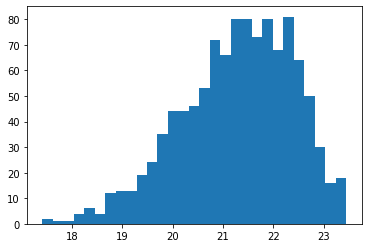

In [6]:
Plotter.plot_dist(_,np.linspace(min(_),max(_),30))

Checking the footprint

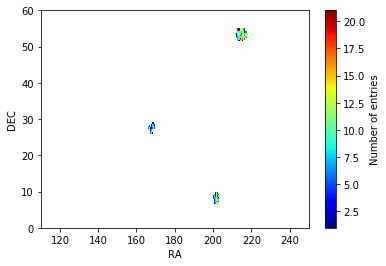

In [7]:
fig,  ax = plt.subplots()
x.plot_footprint(ax=ax)
ax.set_xlim(110,250)
ax.set_ylim(0,60)
plt.show()

Checking the QSO distribution

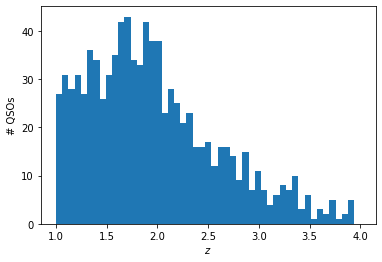

In [8]:
x.plot_dist()

In [9]:
print('Total number of qsos:\t',x.N_obj)
print('Qsos above z=2:\t\t',(x.z>2).sum())

Total number of qsos:	 1099
Qsos above z=2:		 368


Checking number of quasars in a certain region (for comparison with later results)

In [10]:
mask = ( (x.RA > 200)&(x.DEC>45)&(x.RA<230)&(x.z>2) )
mask.sum()

210

-----

### Grabbing all elements (not only qsos)

Catalogue made using: 
```shell
source /global/common/software/desi/desi_environment.sh master
desi_zcatalog -i /global/cfs/cdirs/desi/spectro/redux/andes/tiles/ -o zcat.fits --fibermap
```

In [11]:
x = DrqFile('/global/cscratch1/sd/cramirez/Andes-DR/catalogues/zcat.fits')

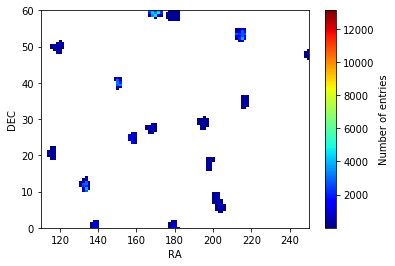

In [12]:
fig,  ax = plt.subplots()
x.plot_footprint(ax=ax)
ax.set_xlim(110,250)
ax.set_ylim(0,60)
plt.show()

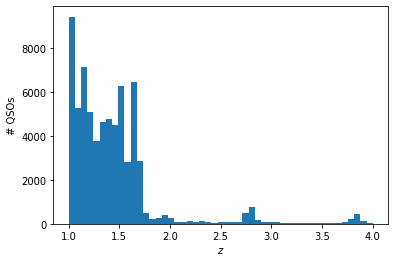

In [13]:
x.plot_dist()

In [14]:
print('Total number of qsos:\t',x.N_obj)
print('Objects above z=2:\t',(x.z>2).sum())

Total number of qsos:	 328500
Objects above z=2:	 6026


In [15]:
mask = ( (x.RA > 200)&(x.DEC>45)&(x.RA<230)&(x.z>2) )
mask.sum()

1058

---

## Grabbing all qso elements

Applying to the previous catalogue the command (python):
```python3
zcat_file=path+'/zcat.fits'
drq_file=path+'/zcat.drq'
picca.utils.desi_from_ztarget_to_drq(ztarget=zcat_file,drq=drq_file,spectype="QSO")
```

In [16]:
x = DrqFile('/global/cscratch1/sd/cramirez/Andes-DR/catalogues/zcat.drq')

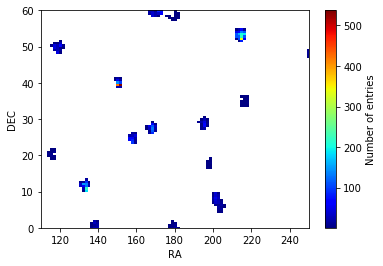

In [17]:
fig,  ax = plt.subplots()
x.plot_footprint(ax=ax)
ax.set_xlim(110,250)
ax.set_ylim(0,60)
plt.show()

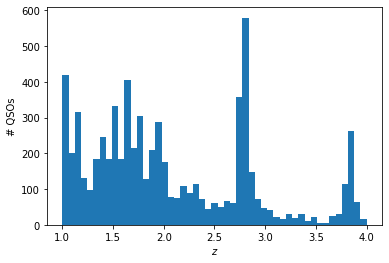

In [18]:
x.plot_dist()

In [19]:
print('Total number of qsos:\t',x.N_obj)
print('Qsos above z=2:\t\t',(x.z>2).sum())

Total number of qsos:	 9358
Qsos above z=2:		 3929


In [20]:
mask = ( (x.RA > 200)&(x.DEC>45)&(x.RA<230)&(x.z>2) )
mask.sum()

826

# Stephen script

Filtering QSO to grab quasars obtained by Stephen Bailey (targetids from those quasars obtained before and saved into file):

In [21]:
import glob
from pathlib import Path
andes_location = '/global/cfs/cdirs/desi/spectro/redux/andes/tiles/'

andes_path = Path(andes_location)

all_tiles = []
for x in sorted(andes_path.iterdir()):
    all_tiles.append(int(Path(x).name))

In [22]:
tiles = all_tiles

In [23]:
zbestfiles = []
for tile in map(str,tiles):
    tile_path = Path(andes_location+'/'+tile)
#     obs = max(tile_path.iterdir())
    for obs in tile_path.iterdir():
        zbestfiles.extend( glob.glob(str(obs) +'/zbest*.fits'))

In [24]:
targetids = np.loadtxt(tids_path,dtype=int)
class zBestUsingStephenQsos(zBestFilesMiniSV):
    @cached_property
    def qsos_target_ids(self):
        previous_targetids = list()
        tids= list()
        with self.open_hdulists():
            for h in self.hdulists:
                h_tids         = h[1].data['TARGETID']
                valid_tids     = h_tids[np.in1d(h_tids,targetids)]
                new_valid_tids = valid_tids[np.in1d(valid_tids,previous_targetids,invert=True)]
                new_valid_tids = list(set(new_valid_tids))
                previous_targetids.extend(new_valid_tids)
                tids.append(new_valid_tids)
            return tids

In [25]:
x = zBestUsingStephenQsos(zbestfiles)

In [26]:
x.N_obj

1514

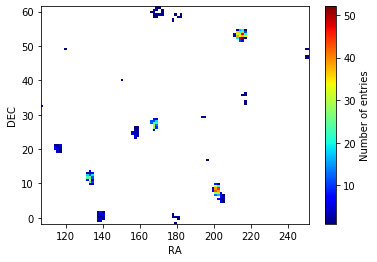

In [27]:
x.plot_footprint()

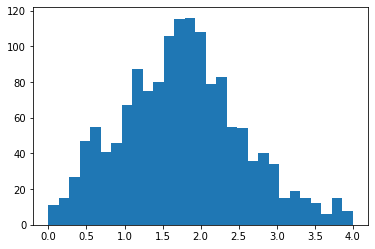

In [28]:
Plotter.plot_dist(x.z, bins=np.linspace(0,4,30))

In [29]:
(x.z>2).sum()

536

In [30]:
(x.z<1).sum()

288

In [31]:
mask = ( (x.RA > 200)&(x.DEC>45)&(x.RA<230)&(x.z>2) )
mask.sum()

197

## How much differ Stephen script from cristophe drq?

In [32]:
import fitsio

In [33]:
stephen_targetids = np.loadtxt(tids_path, dtype= int)

In [34]:
cristophe_targetids = fitsio.read('/global/cfs/cdirs/desi/science/lya/tests_andes/qso_catalogs/preliminary_christophe_20200622.fits')['thing_id']

Elemetns in Stephen not in Cristophe:

In [35]:
np.in1d(stephen_targetids,cristophe_targetids, invert=True).sum()

626

Elements in Cristophe not in Stephen

In [36]:
np.in1d(cristophe_targetids,stephen_targetids, invert=True).sum()

211

Shared elements:

In [37]:
len(cristophe_targetids)-np.in1d(cristophe_targetids,stephen_targetids,invert=True).sum()

888

In [38]:
stephen = zBestUsingStephenQsos(zbestfiles)

In [39]:
michael = DrqFile('/global/cfs/cdirs/desi/science/lya/tests_andes/qso_catalogs/preliminary_christophe_20200622.fits')

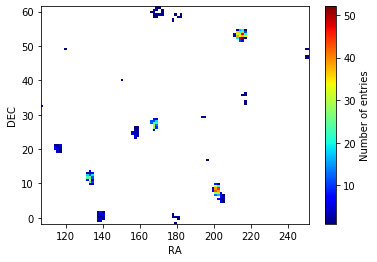

In [40]:
stephen.plot_footprint()

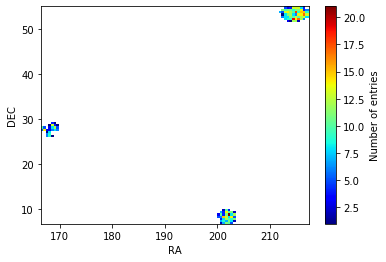

In [41]:
michael.plot_footprint()

In [42]:
bins = np.linspace(0,4,30)

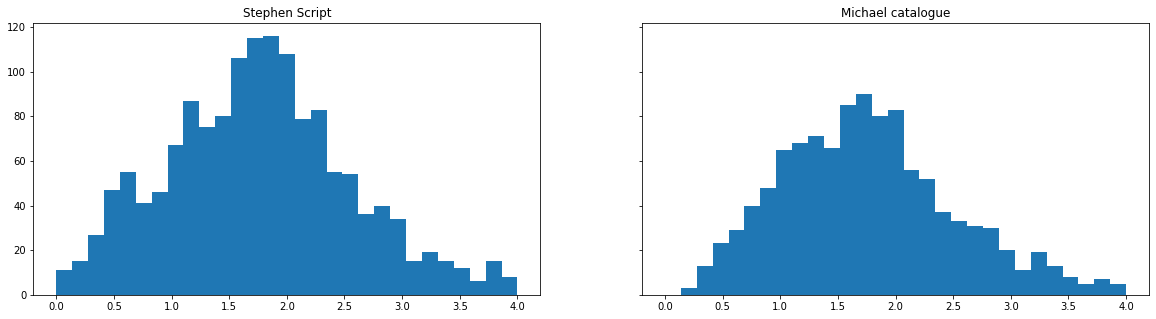

In [44]:
fig1, ax_array = plt.subplots(1,2, sharex=False, sharey=True, figsize=(20,5))
ax1,ax2 = ax_array
Plotter.plot_dist(stephen.z,bins,ax=ax1)
Plotter.plot_dist(michael.z,bins,ax=ax2)
ax1.set_title('Stephen Script')
ax2.set_title('Michael catalogue')
plt.show()

# Obtaining Stephen tids

This part of the notebook should be run with the DESI master kernel:

In [2]:
import glob
import numpy as np
import fitsio

In [3]:
zbfiles = sorted(glob.glob("/global/cfs/cdirs/desi/spectro/redux/andes/tiles"+'/*/*/zbest*.fits'))

In [4]:
basedir = "/global/cfs/cdirs/desi/spectro/redux/andes/"

zqso = list()
targetids = list()

#- Target mask bits for CMX minisv2 and SV0
qsoMask = 36028797018968064

previous_targetids = list()

nstar = 0

zbfiles = sorted(glob.glob(basedir+'/tiles/*/*/zbest*.fits'))
for filename in zbfiles:
    zb = fitsio.read(filename, 'ZBEST')
    fm = fitsio.read(filename, 'FIBERMAP')

    targetid, ii = np.unique(fm['TARGETID'], return_index=True)
    assert np.all(zb['TARGETID'] == fm['TARGETID'][ii])
    cmx_target = fm['CMX_TARGET'][ii]

    isQSO = (zb['SPECTYPE'] == b'QSO') & (zb['ZWARN'] == 0)
    isNew = np.in1d(targetid, list(previous_targetids), invert=True) & (zb['ZWARN'] == 0)

    isQSO = isNew & isQSO & ((cmx_target & qsoMask) != 0)

    zqso.append(zb['Z'][isQSO])
    targetids.append(zb['TARGETID'][isQSO])
    

    previous_targetids.extend(targetid[isNew])

zqso = np.concatenate(zqso)
targetids = np.concatenate(targetids)

In [52]:
len(targetids)

1514